### install packages and tools

In [ ]:
!pip install pandas numpy numba matplotlib networkx bottleneck==1.4.0

In [ ]:
!conda install -y pygraphviz genomic_address_service scikit-learn cgmlst-dists

In [ ]:
!sudo apt install -y libcairo2-dev

### download test cgMLST data and generate clustering and metadata

In [15]:
!wget -q https://github.com/tseemann/cgmlst-dists/raw/master/test/100.tab
!cgmlst-dists 100.tab | sed -e 's@^cgmlst-dists@@1' > 100.distance.tab

This is cgmlst-dists 0.4.0
Loaded 100 samples x 3016 allele calls
Calculating distances: 100.00%
Writing distance matrix to stdout...

Done.


In [16]:
!gas mcluster -i 100.distance.tab -o 100.dist.gas.mcluster.output -t 2000,1000,500,200,100,50,10,5,0

In [17]:
!cut -f 1,3 100.dist.gas.mcluster.output/clusters.text >100.metadata.tsv
!sed -i 's@id\tlevel_1@sample\tgroup@g' 100.metadata.tsv

### load packages for script

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl
import pylab as plt
import numpy as np

### MST generation script - adapted from https://dmnfarrell.github.io/bioinformatics/mst-python

In [2]:

def make_legend(fig, colormap, loc=(1.05, .6), title='',fontsize=12):
    """Make a figure legend wth provided color mapping"""

    import matplotlib.patches as mpatches
    pts=[]
    for c in colormap:
        pts.append(mpatches.Patch(color=colormap[c],label=c))
    fig.legend(handles=pts,bbox_to_anchor=loc,fontsize=fontsize,title=title)
    return pts

def get_color_mapping(df, col, cmap=None, seed=1):
    """Get random color map for categorcical dataframe column"""

    c = df[col].unique()
    if cmap == None:
        rcolors = random_colors(len(c),seed)
    else:
        cmap = mpl.cm.get_cmap(cmap)
        rcolors = [cmap(i) for i in range(len(c))]
    colormap = dict(zip(c, rcolors))
    newcolors =  [colormap[i] if i in colormap else 'Black' for i in df[col]]
    return newcolors, colormap

def dist_matrix_to_mst(distance_matrix, df=None, colorcol=None, labelcol=None, colormap=None,
                       cmap_name='Set2', node_size=4, font_size=6, with_labels=False,
                       edge_labels=False, legend_loc=(1, .7), ax=None):
    """
    Dist matrix to minimum spanning tree
    Args:
        distance_matrix: matrix as dataframe
        df: meta data with index corresponding to node names of tree
        colorcol: column in meta table to color nodes by
        labelcol: column in meta table to label nodes by
        colormap: a mapping of node names to colors
        cmap_name: name of an mpl colormap to apply instead of providing colormap
        node_size: size of nodes
        with_labels: whether to plot labels on nodes
        legend_loc: location of legend
    """

    if ax == None:
        fig,ax=plt.subplots(figsize=(20,20))
    import networkx as nx
    from networkx.drawing.nx_agraph import graphviz_layout

    G = nx.Graph()

    for i, row in distance_matrix.iterrows():
        for j, weight in row.items():
            G.add_edge(i, j, weight=weight)

    T = nx.minimum_spanning_tree(G, algorithm='kruskal')
    # Compute edge lengths based on distances
    edge_lengths = [T[u][v]['weight'] for u, v in T.edges()]
    # Plot the minimum spanning tree with edge lengths proportional to distances
    pos = graphviz_layout(T)
    labels = nx.get_edge_attributes(T, 'weight')
    if df is not None:
        l = [label for label in T.nodes if label in df.index]
        df = df.loc[l]
        if colormap is None:
            colors,cmap = get_color_mapping(df, colorcol, cmap_name)
        else:
            #custom colormap if provided
            colors = [colormap[i] if i in colormap else 'black' for i in df[colorcol]]
            cmap = colormap
        #print (cmap)
        C = dict(zip(df.index, colors))
        node_colors = [C[node] if node in C else 'Black' for node in T.nodes()]
        #checks that colormap matches nodes so legend doesn't have crap in it
        #cmap = check_keys(cmap, df[colorcol].unique())
        #add legend for node colors
        p = make_legend(ax.figure, cmap, loc=legend_loc, title=colorcol,fontsize=9)

    else:
        node_colors = 'black'
    nx.draw_networkx(T, pos, node_color=node_colors, node_size=node_size,
                     font_size=font_size, with_labels=with_labels, ax=ax)
    if edge_labels == True:
        nx.draw_networkx_edge_labels(T, pos, edge_labels=labels, font_size=font_size*.7, ax=ax)

    if labelcol not in [None,'']:
        node_labels = {node:df.loc[node][labelcol] if node in df.index else '' for node in T.nodes()}
        #print (node_labels)
        nx.draw_networkx_labels(T, pos, labels=node_labels, font_size=font_size,
                 horizontalalignment='right',verticalalignment='top')
    ax.axis('off')
    return T, pos

In [3]:
def dm_cluster(distance_matrix, t, linkage='average'):
    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(distance_threshold=t, n_clusters=None,
                                         linkage=linkage, metric='precomputed').fit(distance_matrix)
    labels = clustering.labels_+1
    clusters = pd.DataFrame(labels,columns=['cluster'],index=distance_matrix.index)
    return labels, clusters


### run MST generation script

/tmp/ipykernel_2116/3622447796.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(cmap)


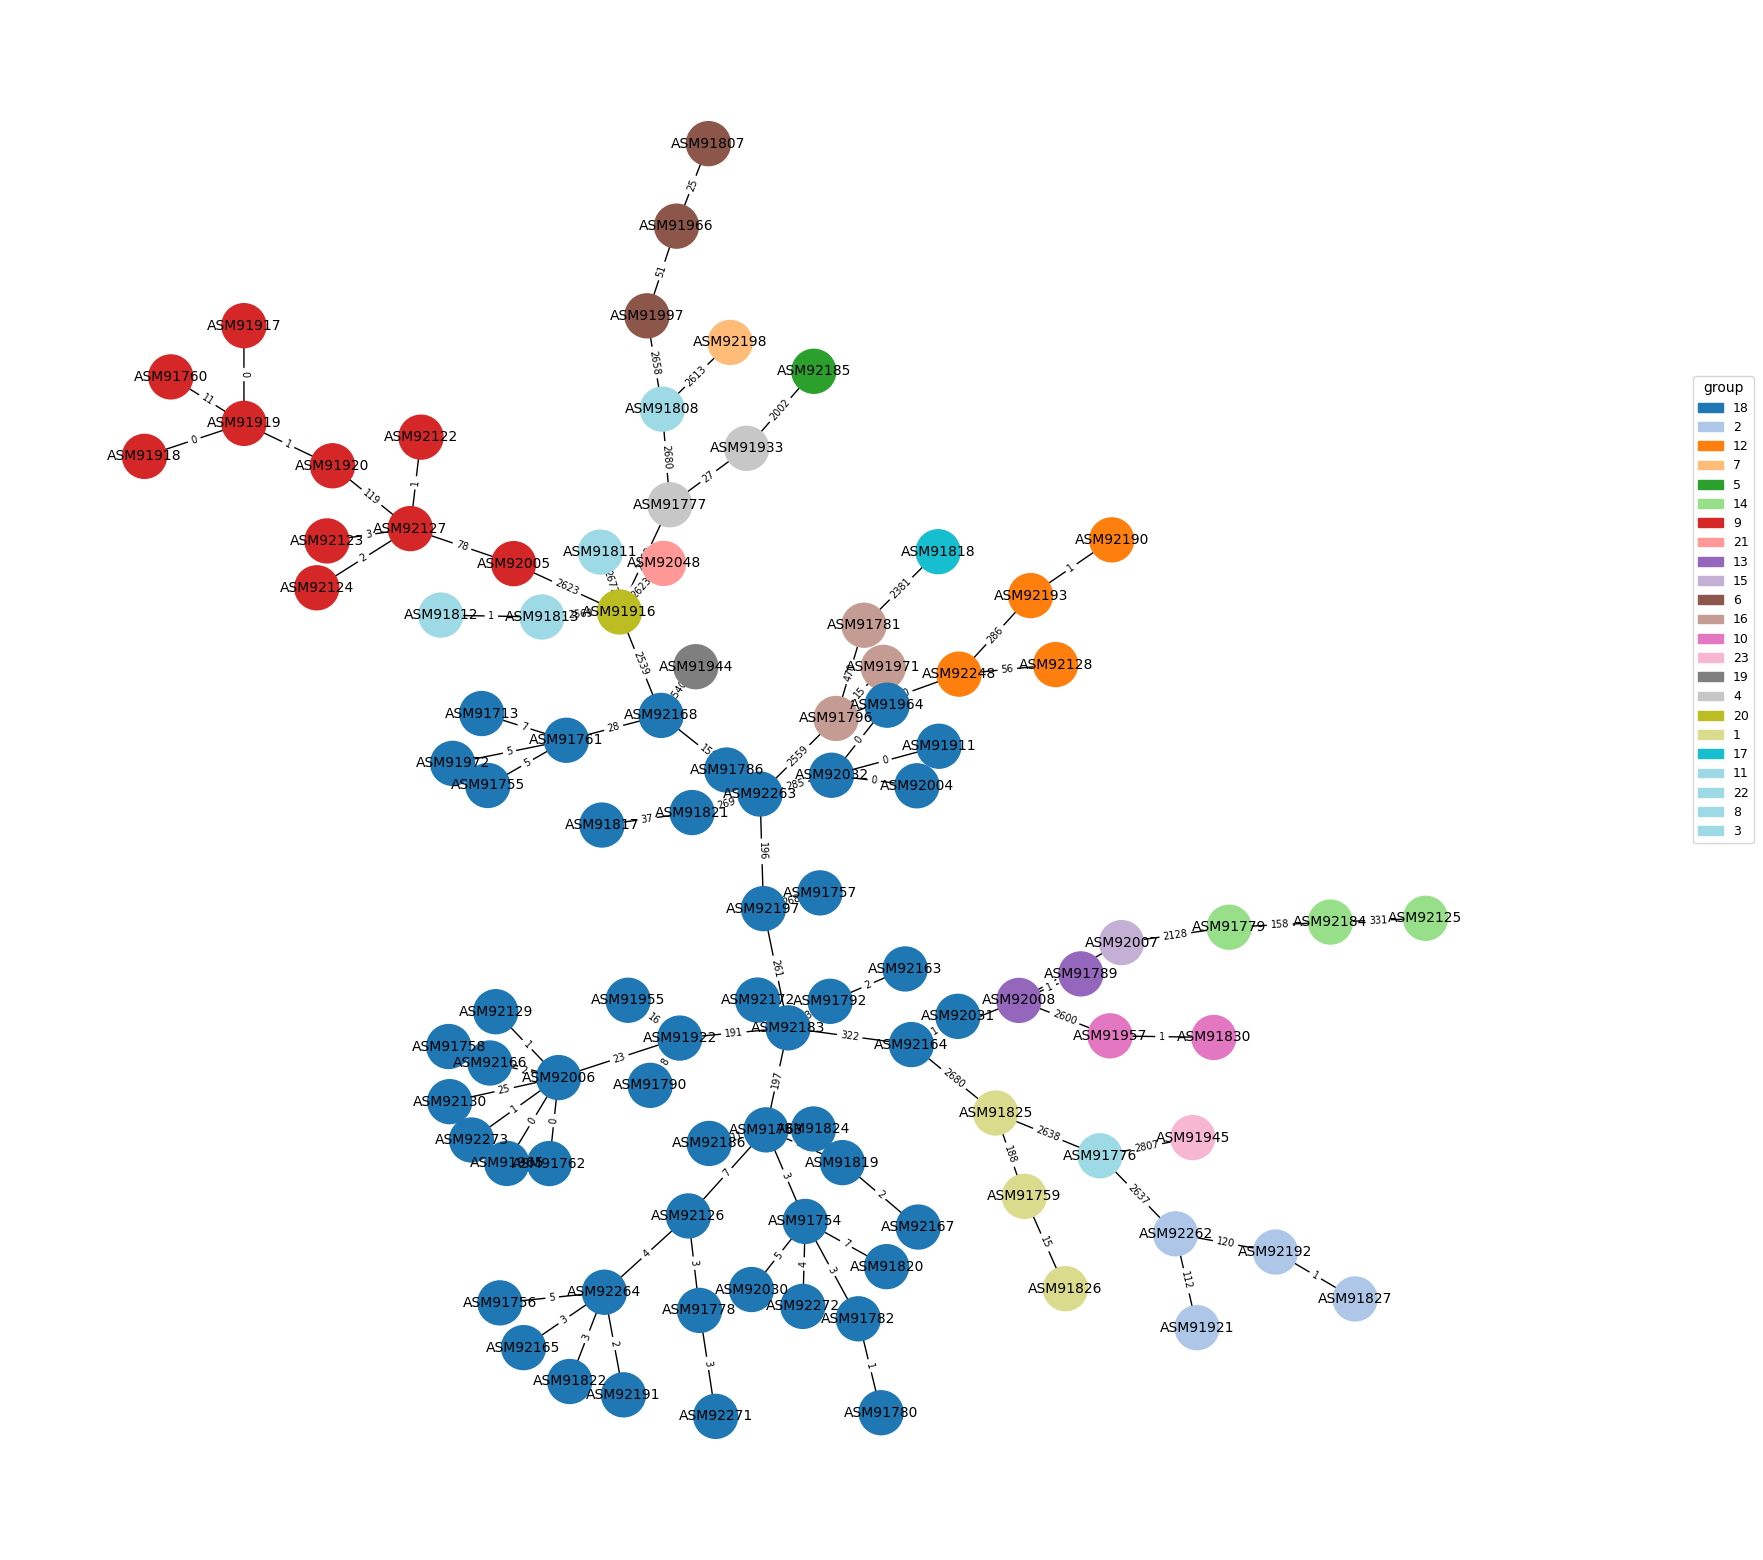

In [4]:
dm = pd.read_csv('100.distance.tab',sep='\t',index_col=0,header=0)
meta = pd.read_csv('100.metadata.tsv',sep='\t',index_col=0,header=0)

labels,cl = dm_cluster(dm, 20)
meta['cluster2'] = labels

T,pos=dist_matrix_to_mst(dm, meta, colorcol="group",node_size=1000,font_size=10, with_labels=True, edge_labels=True,cmap_name='tab20')
#plt.savefig("100.dist.gas.mcluster.MST.png", dpi=1000)